In [1]:
import pandas as pd
import gzip
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

/mnt2/wisniewski/nazanin/NeuralLMs/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
# model = AutoModelForMaskedLM.from_pretrained('google/multiberts-seed_0').to(device)

cuda


## Surprisals

In [24]:
surprisals = pd.read_csv('../results/toy_surprisals.txt', sep='\t')
surprisals

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples
0,0,constraint,7480,14.581974,NaN,0.000000,1
1,0,exploring,9474,14.721372,NaN,0.000000,1
2,0,of,142,13.217982,0.359066,0.000000,512
3,0,the,27912,16.013855,0.386750,0.000000,512
4,20000,constraint,2790,16.842049,NaN,0.000000,1
...,...,...,...,...,...,...,...
111,1900000,the,0,0.387125,0.949621,0.923828,512
112,2000000,constraint,728,14.549789,NaN,0.000000,1
113,2000000,exploring,56,10.402106,NaN,0.000000,1
114,2000000,of,0,0.336895,1.169644,0.949219,512


## View attentions matrices

The self-attention $a_{j \rightarrow i}$ describes how important is the $j$-th token to build the representation of the $i$-th token. We know that $a_{j \leftarrow j}$ is a probability distribution.

The encoder attention is a list of **12** tensors, one for each `BertEncoderLayer` in the model.

Each attention is a `[batch_size ✕ n_heads ✕ input_sequence_length ✕ input_sequence_length]`.

**Example:**

the attention weight of the second_last token (-2) in the first attention head (0) of the last layer (-1), with respect to the third token (2):

`attentions[-1][0][-2][2]`

In [4]:
def attention_matrices(attentions, sequence, tokenizer):
    n_heads = attentions.shape[0]
    seq_tokens = tokenizer.tokenize(sequence)
    seq_len = len(seq_tokens)
    fig, ax = plt.subplots(n_heads, 1, figsize=(seq_len // 4, n_heads), sharex=True)

    for layer in range(n_heads):
        plt.sca(ax[layer])
        # Remove padding tokens from attention matrix
        self_attention = attentions[layer, :seq_len]

        df_attention = pd.DataFrame(data=self_attention.reshape(1, -1),  # Reshape to a row vector
                                    index=['[MASK]'],
                                    columns=seq_tokens)

        plot = sns.heatmap(df_attention, cmap="crest")
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        plot.set_xlabel("tokens")
        # plot.set_ylabel("[MASK]")

    plt.tight_layout()
    plt.show()

In [28]:
with gzip.open('../results/4ex_att_hs.pickle.gz', 'rb') as f:
    toy_att_hs = pickle.load(f)

toy_att_hs = pd.DataFrame(toy_att_hs)
toy_att_hs

,step,sequence,1st_layer_attentions,6th_layer_attentions,last_layer_attentions,1st_layer_hidden_states,6th_layer_hidden_states,last_layer_hidden_states
0,0,[CLS] turan cited ball's lack of [MASK] when w...,"[[0.012571751, 0.010714171, 0.011511954, 0.015...","[[0.018160338, 0.01111132, 0.013891903, 0.0135...","[[0.015209573, 0.012172604, 0.015836501, 0.015...","[0.5670556, -0.70738256, 0.16242988, -0.324278...","[1.6499794, -0.1876529, 0.93366903, -0.6897908...","[0.63210857, -0.73800594, 0.6110188, -1.090390..."
1,0,[CLS] the flight deck had eight permanent stor...,"[[0.011533796, 0.008013432, 0.009929911, 0.012...","[[0.014165661, 0.009534655, 0.021158291, 0.009...","[[0.013987694, 0.012201425, 0.010457766, 0.016...","[1.73341, 0.5504038, -0.26146516, -0.92348, 0....","[2.138049, 0.73583424, 0.45893022, -0.9239309,...","[1.1983768, -0.054673992, 1.2820964, -1.245691..."
2,0,[CLS] it was fitted with fire fighting foam an...,"[[0.012953467, 0.015198409, 0.010570023, 0.014...","[[0.015212179, 0.015237265, 0.013418278, 0.013...","[[0.015212145, 0.015801895, 0.011601858, 0.014...","[1.077022, -0.016053334, 1.4660655, -0.9907943...","[2.0458155, 0.6682396, 2.3819685, -0.7792431, ...","[1.4607682, 0.56458974, 2.0408604, -1.7000054,..."
3,0,[CLS] it was 12 @. @ 1 metres long and had a c...,"[[0.014352492, 0.015839592, 0.010592085, 0.014...","[[0.016968269, 0.017308513, 0.013528574, 0.010...","[[0.01406064, 0.015170526, 0.013362268, 0.0150...","[1.4489819, 0.70253986, 1.0023994, -0.510217, ...","[1.9155668, 0.9658726, 1.5458523, -0.63569295,...","[0.83130723, 1.0952954, 1.9511776, -1.0922956,..."
4,0,[CLS] to recover the aircraft the collapsible ...,"[[0.018518135, 0.016654434, 0.028943498, 0.021...","[[0.027021714, 0.020936297, 0.02936525, 0.0182...","[[0.023860464, 0.02301136, 0.023029713, 0.0231...","[0.7707335, 0.23744231, 0.8322876, -0.66660315...","[1.1726712, 0.7053242, 1.4426862, -0.75155514,...","[0.625068, 0.37470692, 1.5983753, -1.5088762, ..."
...,...,...,...,...,...,...,...,...
29749,2000000,[CLS] intelligence officers reported an attack...,"[[0.025711827, 0.018343952, 0.026242323, 0.022...","[[0.14529872, 0.0013951348, 0.0015821997, 0.00...","[[0.0001947326, 0.009825054, 0.009081433, 0.00...","[-0.3245887, -0.49050102, -0.17097422, -0.1131...","[-0.5024461, -0.021962676, 0.18272603, -0.1086...","[-0.10382371, 0.6074112, 0.44598362, -0.444731..."
29750,2000000,[CLS] its mission in the forthcoming attack wa...,"[[0.017314114, 0.005937349, 0.017314816, 0.012...","[[0.15406686, 0.006820085, 0.003380538, 0.0022...","[[0.0031058383, 0.007304773, 0.0004439867, 0.0...","[0.099780835, 0.1265872, -0.030854104, -0.3208...","[-0.31159016, 0.051276118, 0.19290955, -0.2322...","[0.06977252, -0.27114874, 0.44316825, -0.27465..."
29751,2000000,"[CLS] consequently, they expected lighter resi...","[[0.030893018, 0.029366031, 0.019497365, 0.016...","[[0.19918455, 0.0013972338, 0.010904923, 0.001...","[[0.00029185193, 0.0011812939, 8.795503e-05, 0...","[0.06454525, -0.04829275, -0.19809811, -0.3104...","[-0.50043887, -0.05013673, 0.1553985, -0.23155...","[-0.2612405, 0.5629449, 0.5001984, 0.08673042,..."
29752,2000000,[CLS] with the critical parts of cloverleaf hi...,"[[0.016269723, 0.010579517, 0.011842334, 0.012...","[[0.16340795, 0.010914343, 0.008147107, 0.0044...","[[0.0006282168, 0.016902108, 0.008639287, 0.01...","[0.23890576, -0.063276716, 0.18186823, 0.01967...","[0.04931646, -0.35381672, 0.0594423, 0.1311878...","[-0.635884, -0.29966992, 0.6112783, 0.78392226..."


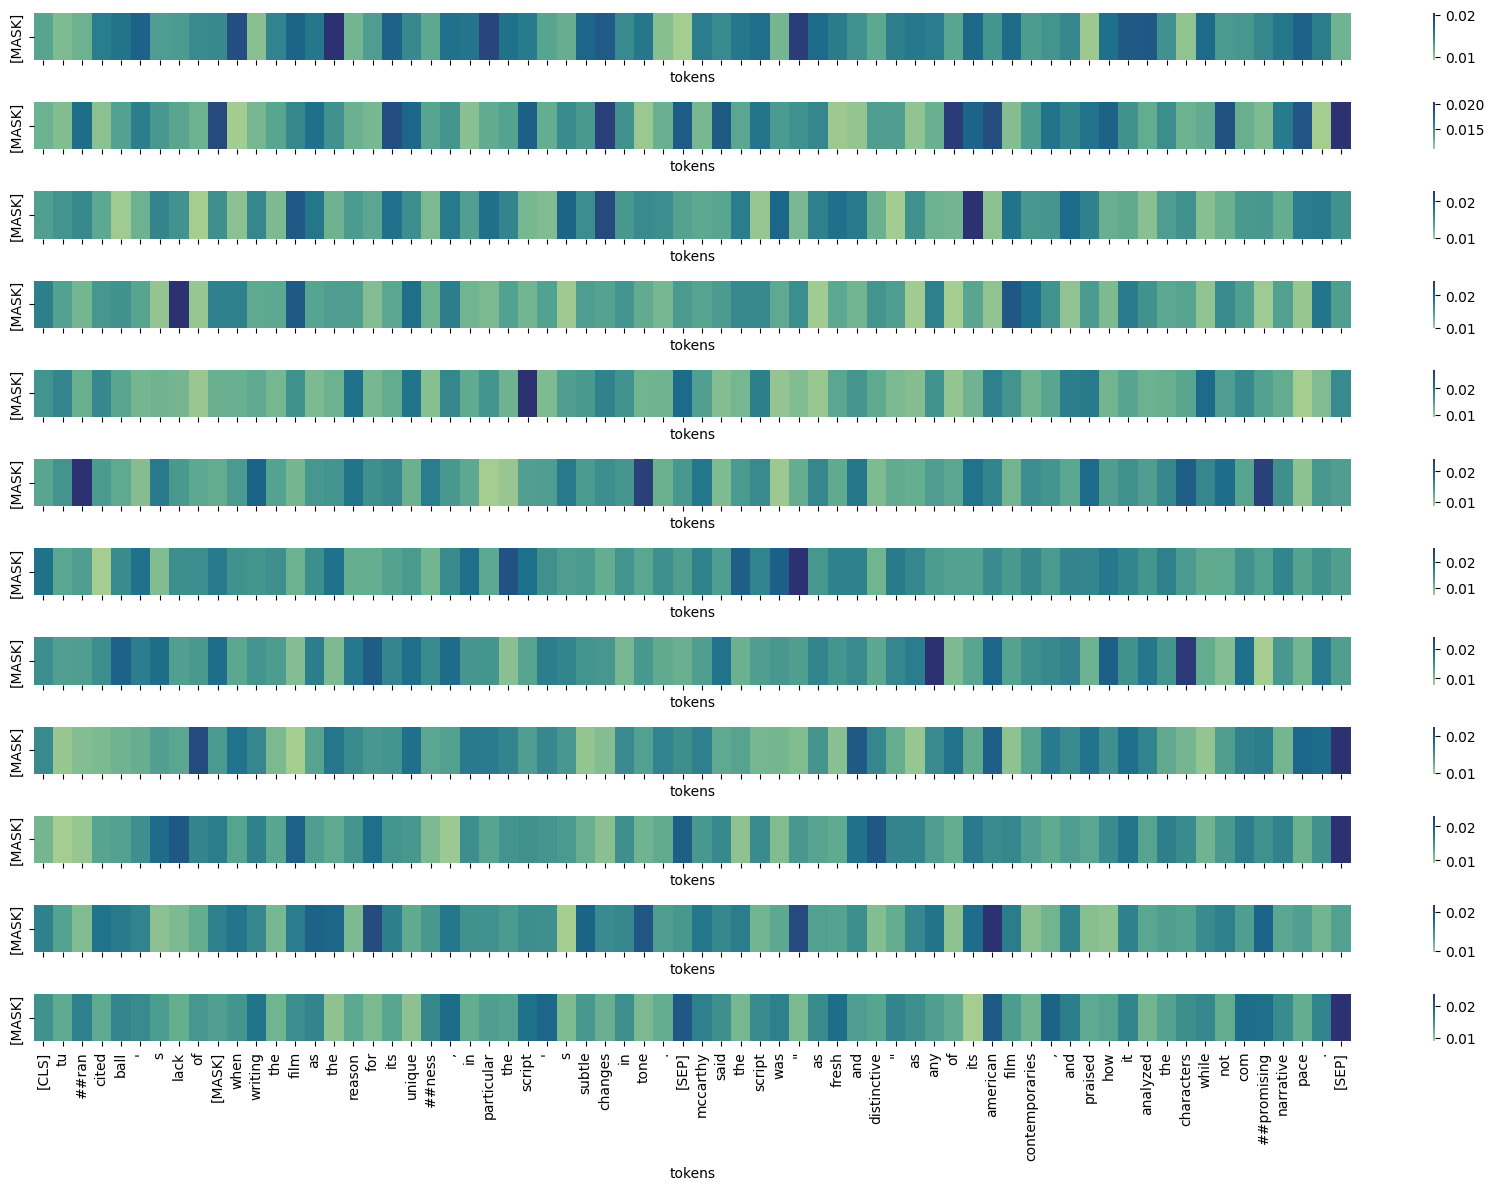

In [29]:
first_row = toy_att_hs.iloc[0]
attention_matrices(first_row['1st_layer_attentions'], first_row['sequence'], tokenizer)

## View hidden states

The encoder hidden_states is a list of **13** tensors, which are the inputs and outputs of each `BertEncoderLayer` in the model.

Each hidden_state is a `[batch_size ✕ input_sequence_length ✕ hidden_size]`.

**Example:**

The first hidden state on the last layer: `hidden_states[-1][0, :]`